In [80]:
import queue
from experiment_information import *
from experiments.sweep_generalization_error import *
from data import *
from _version import __version__
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_erm = dbHandler.get_erms()
    # delete incomplete experiments (bad, deletes running experiments...)
    dbHandler.delete_incomplete_experiments()
print("Current code version, ", __version__)

Current code version,  21


In [82]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "13"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(2)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,completed
18,1a30ff65-e1f9-4a92-93a3-f543c25699d6,Default Experiment,938.910155,21,2023-04-05 22:04:02,1,10,"[0.2, 0.8, 1.3, 1.7, 2.0, 2.5]","[0.0, 0.1, 0.2, 0.3]",[1e-05],[2],500,"[""sklearn""]",1
17,3af63965-dc38-4e97-9215-a6dc9725c799,Default Experiment,929.668077,21,2023-04-05 21:45:24,1,10,"[0.2, 0.8, 1.3, 1.7, 2.0, 2.5]","[0.0, 0.01, 0.02, 0.03]",[1e-05],[2],1000,"[""sklearn""]",1


In [83]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

1a30ff65-e1f9-4a92-93a3-f543c25699d6


In [84]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_error"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes
df = state_evolution.join(gd)
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_error_state_evolution","training_error_erm"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std])
# display all columns
pd.set_option('display.max_columns', None)
df

generalization_error_state_evolution       \
                                                          mean  std   
alpha epsilon tau lam                                                 
0.2   0.0     2.0 0.00001                             0.478884  0.0   
      0.1     2.0 0.00001                             0.479006  0.0   
      0.2     2.0 0.00001                             0.478993  0.0   
      0.3     2.0 0.00001                             0.478982  0.0   
0.8   0.0     2.0 0.00001                             0.464972  0.0   
      0.1     2.0 0.00001                             0.464167  0.0   
      0.2     2.0 0.00001                             0.463877  0.0   
      0.3     2.0 0.00001                             0.463688  0.0   
1.3   0.0     2.0 0.00001                             0.460130  0.0   
      0.1     2.0 0.00001                             0.458207  0.0   
      0.2     2.0 0.00001                             0.457142  0.0   
      0.3     2.0 0.00001                             0.455671  0.0   
1.7   0.0     2.0 0.00001                             0.457674  0.0   
      0.1     2.0 0.00001                             0.453594  0.0   
      0.2     2.0 0.00001                             0.450086  0.0   
      0.3     2.0 0.00001                             0.447554  0.0   
2.0   0.0     2.0 0.00001                             0.456326  0.0   
      0.1     2.0 0.00001                             0.447729  0.0   
      0.2     2.0 0.00001                             0.444094  0.0   
      0.3     2.0 0.00001                             0.441689  0.0   
2.5   0.0     2.0 0.00001                             0.443128  0.0   
      0.1     2.0 0.00001                             0.438087  0.0   
      0.2     2.0 0.00001                             0.435335  0.0   
      0.3     2.0 0.00001                             0.433437  0.0   

                          generalization_error_erm_erm            \
                                                  mean       std   
alpha epsilon tau lam                                              
0.2   0.0     2.0 0.00001                     0.479800  0.006023   
      0.1     2.0 0.00001                     0.478526  0.006922   
      0.2     2.0 0.00001                     0.480832  0.003493   
      0.3     2.0 0.00001                     0.477967  0.004671   
0.8   0.0     2.0 0.00001                     0.466916  0.010021   
      0.1     2.0 0.00001                     0.469816  0.008094   
      0.2     2.0 0.00001                     0.476733  0.010982   
      0.3     2.0 0.00001                     0.482553  0.010314   
1.3   0.0     2.0 0.00001                     0.463998  0.003792   
      0.1     2.0 0.00001                     0.461559  0.013620   
      0.2     2.0 0.00001                     0.466038  0.010215   
      0.3     2.0 0.00001                     0.472577  0.014773   
1.7   0.0     2.0 0.00001                     0.460781  0.006057   
      0.1     2.0 0.00001                     0.470752  0.016949   
      0.2     2.0 0.00001                     0.456253  0.014134   
      0.3     2.0 0.00001                     0.472553  0.015145   
2.0   0.0     2.0 0.00001                     0.453817  0.005326   
      0.1     2.0 0.00001                     0.479700  0.023633   
      0.2     2.0 0.00001                     0.456251  0.017420   
      0.3     2.0 0.00001                     0.459540  0.018403   
2.5   0.0     2.0 0.00001                     0.442210  0.006347   
      0.1     2.0 0.00001                     0.489179  0.012614   
      0.2     2.0 0.00001                     0.463941  0.033508   
      0.3     2.0 0.00001                     0.472689  0.029555   

                          generalization_error_overlap_erm            \
                                                      mean       std   
alpha epsilon tau lam                                                  
0.2   0.0     2.0 0.00001                         0.479

Text(0.5, 1.0, 'Generalization Error Overlap')

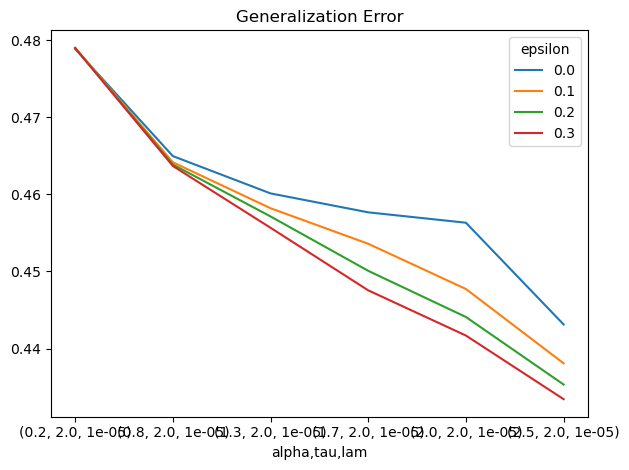

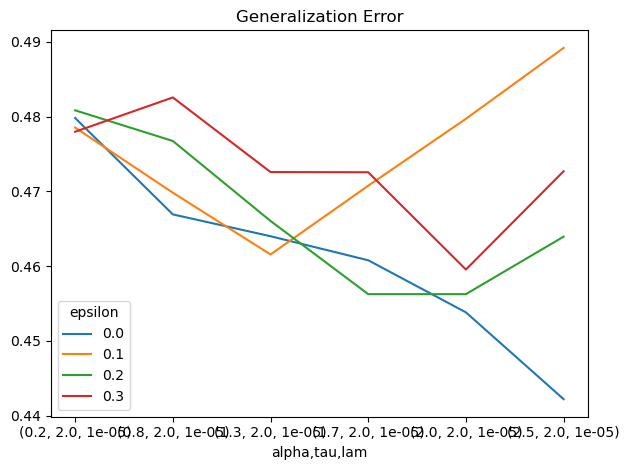

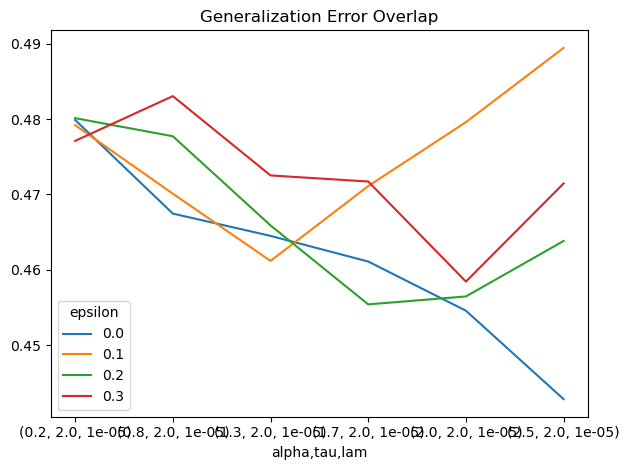

In [85]:
# keep only the alpha in the index
# plot generalization_error_state_evolution vs alpha
# set the title to "Generalization Error"
df["generalization_error_state_evolution"]["mean"].unstack(level=1).plot()
plt.title("Generalization Error")
df["generalization_error_erm_erm"]["mean"].unstack(level=1).plot()
# set the title to "Generalization Error"
plt.title("Generalization Error")
# plot generalization_error_overlap_erm vs alpha
# set the title to "Generalization Error Overlap" 
df["generalization_error_overlap_erm"]["mean"].unstack(level=1).plot()
plt.title("Generalization Error Overlap")


Text(0.5, 1.0, 'Training Error')

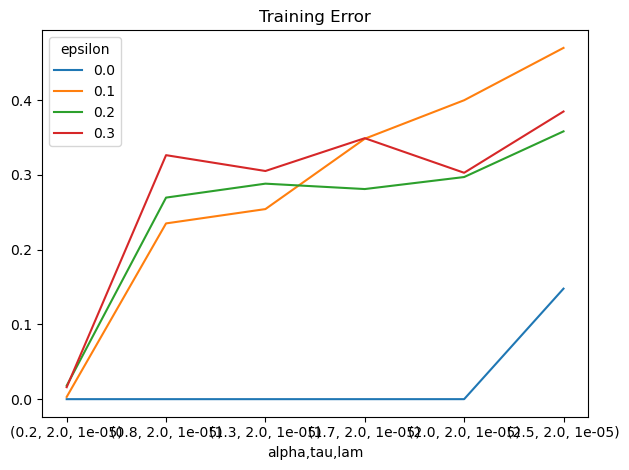

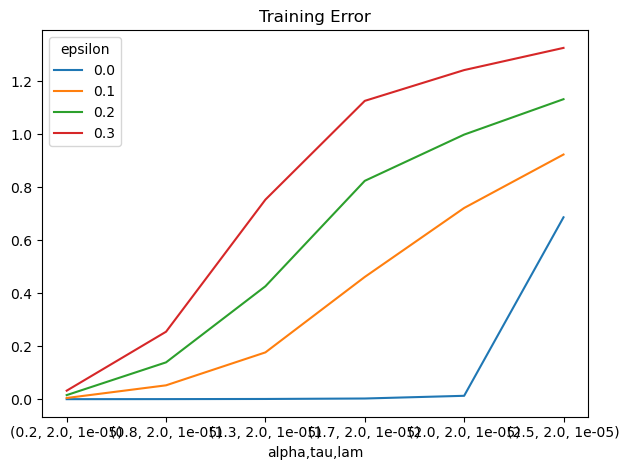

In [86]:
# plot the training_error vs alpha
df["training_error_erm"]["mean"].unstack(level=1).plot()
# set the title to "Training Error"
plt.title("Training Error")
df["training_error_state_evolution"]["mean"].unstack(level=1).plot()
# set the title to "Training Error"
plt.title("Training Error")

In [87]:
# Create a SweepExperiment
experiment = get_default_experiment()
# use json dump to save the experiment parameters
with open("sweep_experiment.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)